# Music genre classification

This notebook showcases a Convolutional Neural Network (CNN) model for predicting the genre of 30-second music clips based on 3-second mel spectrogram segments.
The dataset used is the GTZAN music genre dataset. The raw audio files are first split into 3-second segments. Then, a mel spectrogram is computed for each segment and saved as a .npy file.
The CNN model learns from .npy files and makes predictions in 3 ways : 
- Per-segment prediction – Each individual 3-second segment is classified independently. 
- hard voting - looking at the segments of the whole track, each segment is given the predicted genre, genre prediction for the track is the most frequent genre among the segments
- soft voting - similarly we are looking at each segment of the track, predicting probabilities for each genre, afterwards the probabilities are averaged and the genre with the highest average probability is selected for the full clip.

For more detailed information about model and how it works read README file.

### Imports

In [26]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import librosa
import torch
from torchinfo import summary
from torch.utils.data import DataLoader
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

sys.path.append('./src')
from genre_classifier import GenreClassifier
from spectrogram_dataset import SpectrogramDataset
from train import plot_confusion_matrix

### Spectrogram ilustration

Here will be shown some of the examples of the 3-second mel spectrogram segments

In [2]:
def plot_spectrogram(path):
    m = np.load(path)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(m, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (from .npy file)')
    plt.tight_layout()
    plt.show()

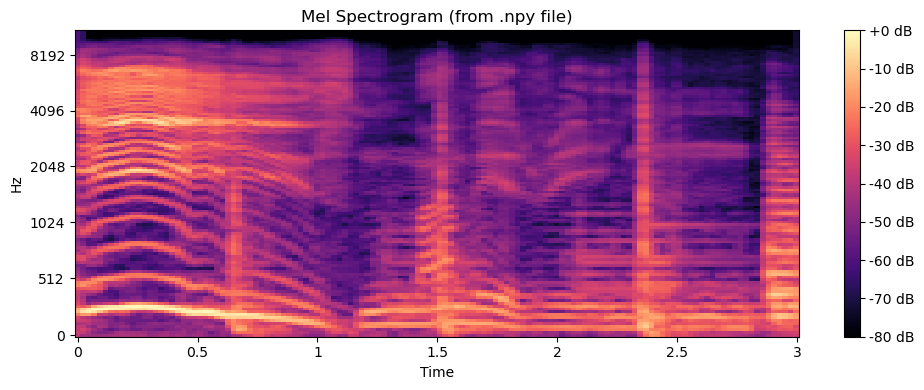

In [3]:
plot_spectrogram(r'data\mel_spectrograms_train\track_blues.00005.wav\track_blues.00005.wav_segment_4.npy')

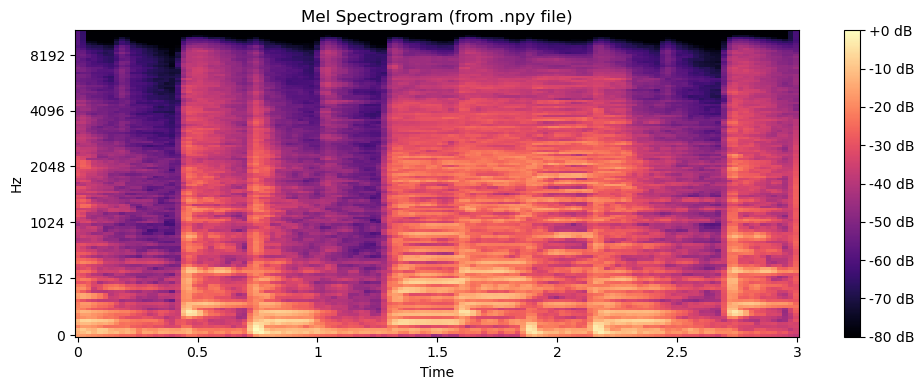

In [4]:
plot_spectrogram(r'data\mel_spectrograms_train\track_rock.00002.wav\track_rock.00002.wav_segment_6.npy')

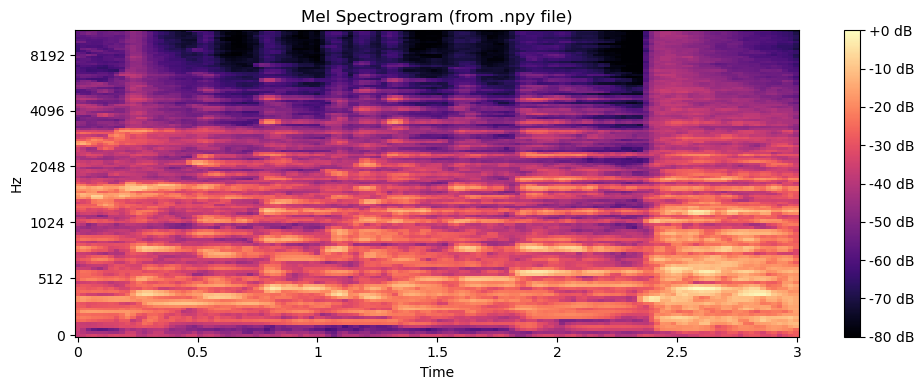

In [5]:
plot_spectrogram(r'data\mel_spectrograms_train\track_classical.00085.wav\track_classical.00085.wav_segment_3.npy')

### Model architecture

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenreClassifier(device)
model.to(device)
model.load('genre_classifier1.pth')

In [10]:
summary(model, input_size=(1, 1, 128, 130))

Layer (type:depth-idx)                   Output Shape              Param #
GenreClassifier                          [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 32, 128, 130]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 130]         64
│    └─ReLU: 2-3                         [1, 32, 128, 130]         --
│    └─Conv2d: 2-4                       [1, 32, 64, 65]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 64, 65]           64
│    └─ReLU: 2-6                         [1, 32, 64, 65]           --
│    └─MaxPool2d: 2-7                    [1, 32, 31, 32]           --
│    └─Dropout2d: 2-8                    [1, 32, 31, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 31, 32]           18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 31, 32]           128
│    └─ReLU: 2-11                        [1, 64, 31, 32]           --
│    └

### Model train history

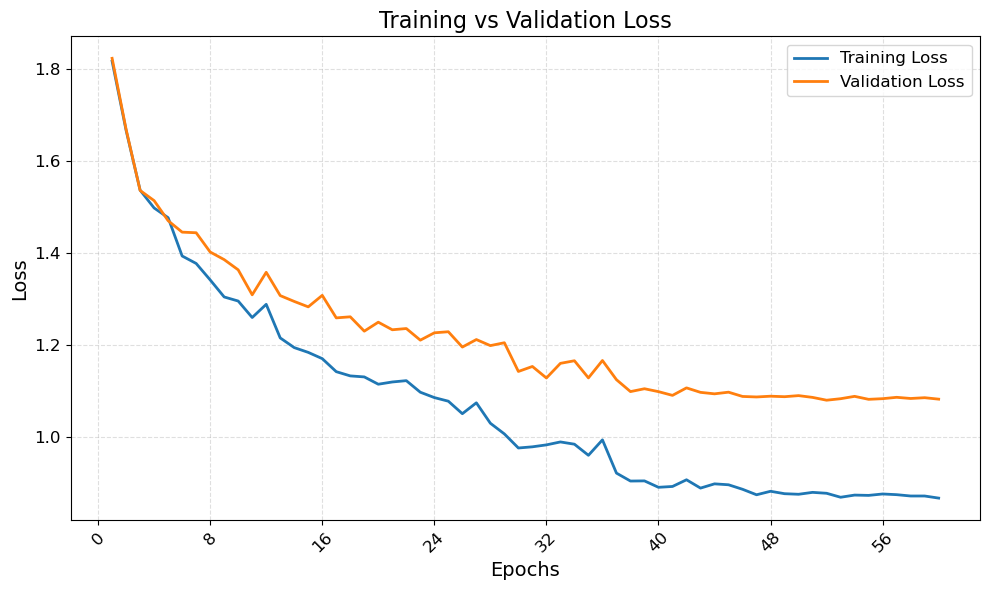

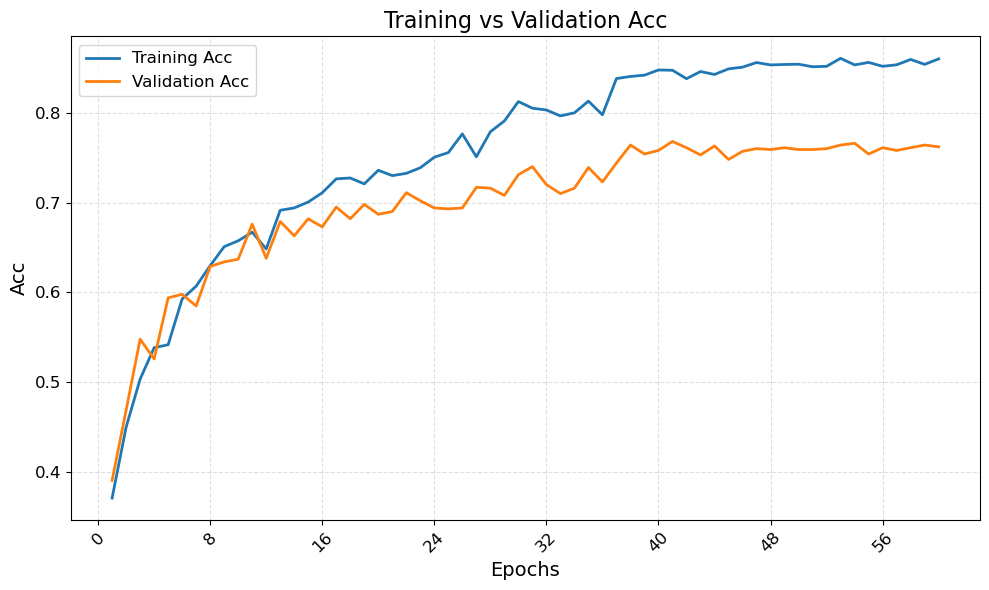

In [12]:
model.plot_training_curves()

### Test set predictions

In [27]:
test_csv = pd.read_csv('data/test.csv')
data_test = test_csv['segment_paths'].to_numpy()
labels_test = test_csv['genre_id'].to_numpy()
dataset_test = SpectrogramDataset(labels_test, data_test)
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)
with open('data/genre_id_to_name.json', 'r', encoding='utf-8') as f:
        genre_id_to_name = json.load(f)
class_names = list(genre_id_to_name.values()) 

Accuracy on test set with soft voting : 0.84


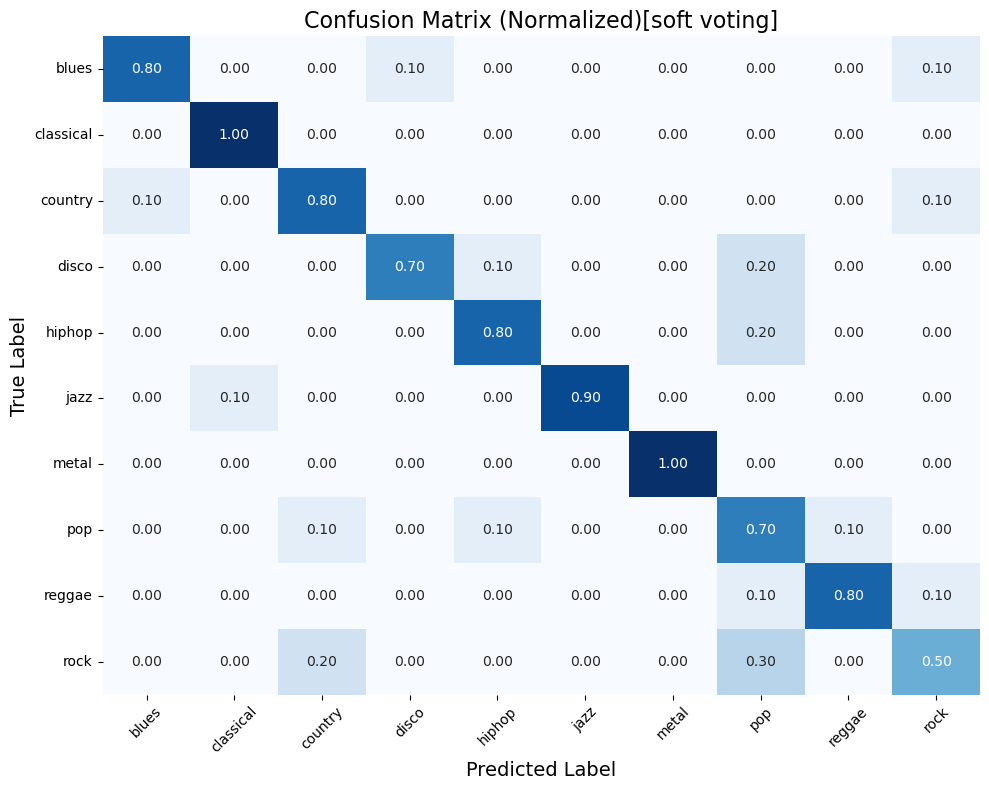

In [28]:
test_loss, test_acc = model.evaluate(loader_test, 'soft', 1000)
print(f'Accuracy on test set with soft voting : {test_acc:.2f}')
pred, true = model.predict(loader_test, 'soft')
plot_confusion_matrix(true, pred, class_names,True, '[soft voting]')

Accuracy on test set with hard voting : 0.85


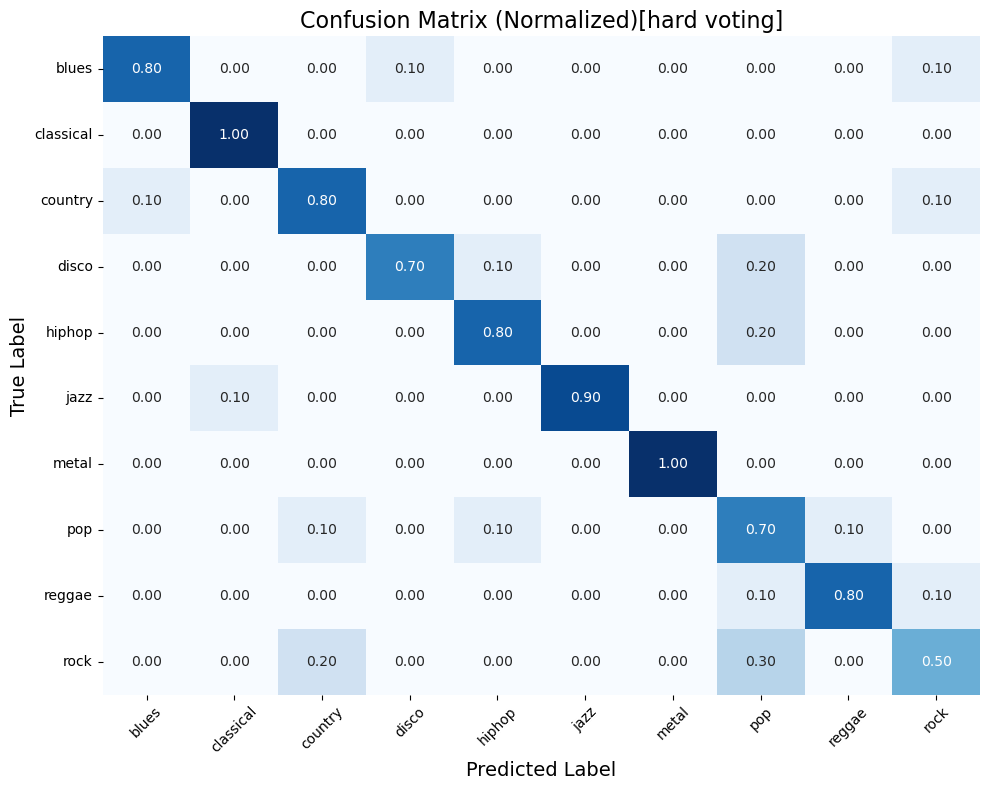

In [29]:
test_loss, test_acc = model.evaluate(loader_test, 'hard', 1000)
print(f'Accuracy on test set with hard voting : {test_acc:.2f}')
pred, true = model.predict(loader_test, 'hard')
plot_confusion_matrix(true, pred, class_names, True, '[hard voting]')

Accuracy on test set per sample : 0.76


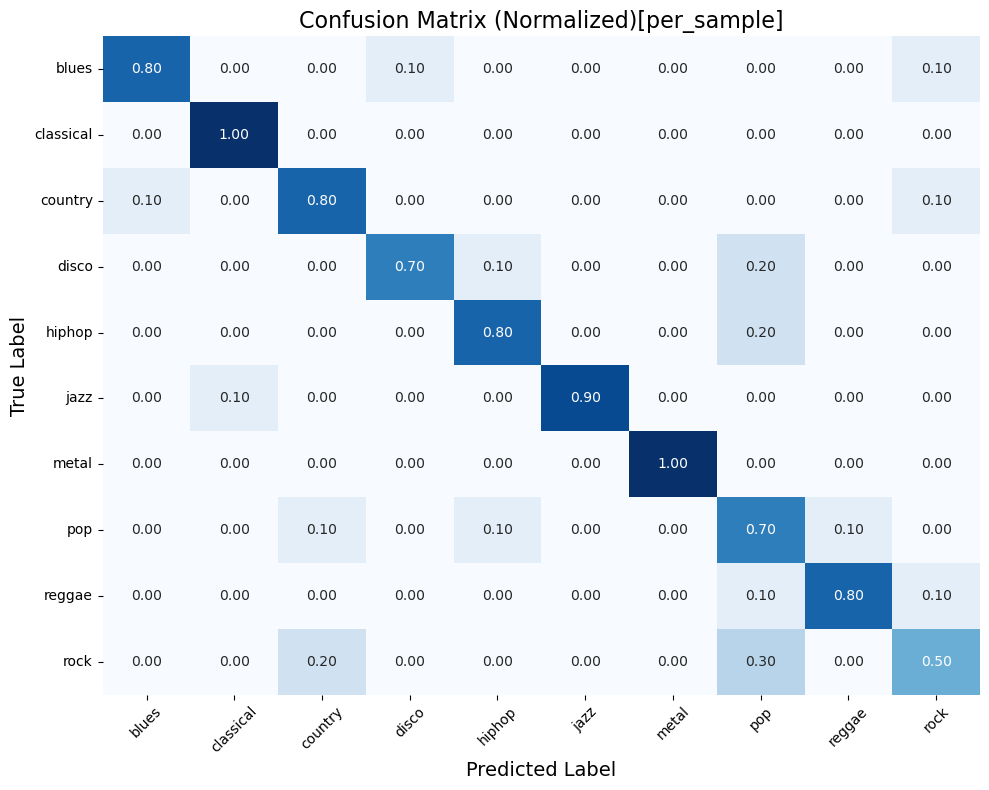

In [30]:
test_loss, test_acc = model.evaluate(loader_test, None, 1000)
print(f'Accuracy on test set per sample : {test_acc:.2f}')
pred, true = model.predict(loader_test, 'hard')
plot_confusion_matrix(true, pred, class_names, True, '[per_sample]')